In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import shap

Using TensorFlow backend


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df = pd.read_csv("gender_stats_preprocessed.csv")
df = df.dropna(axis=1)

In [3]:
x = df.drop(columns=['Country Name'], axis=0)
x = x.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled, columns=df.columns[1:], index=df['Country Name'])

In [12]:
train_data, test_data = train_test_split(df_scaled, random_state=43)

In [13]:
if "Poland" not in test_data.index:
    test_data.loc['Poland'] = train_data.loc['Poland']
    train_data.drop('Poland', inplace=True)

In [14]:
y_train = train_data['Fertility rate, total (births per woman)'].copy()
X_train = train_data.drop('Fertility rate, total (births per woman)', axis=1)

y_test = test_data['Fertility rate, total (births per woman)'].copy()
X_test = test_data.drop('Fertility rate, total (births per woman)', axis=1)

In [16]:
model = keras.Sequential([
    #normalizer,
    layers.Dense(14, activation='relu'),
    layers.Dense(3, kernel_regularizer='l1'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.0001))

In [17]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    verbose=0, epochs=100, batch_size = 5)

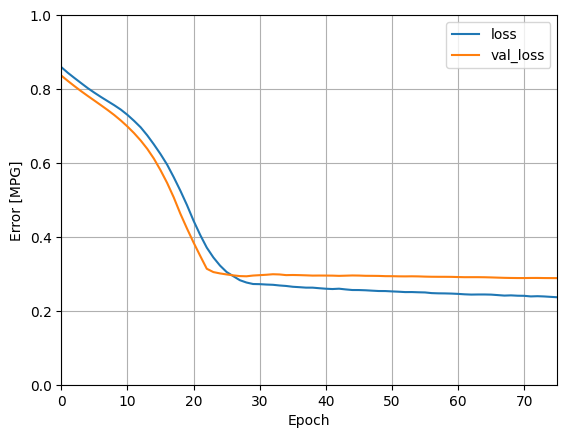

In [18]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlim([0,75])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [21]:
def model_builder(hp):
  model = keras.Sequential()
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 10-512
  hp_units = hp.Int('units', min_value=8, max_value=236, step=32)
  
  model.add(keras.layers.Dense(units=hp_units, activation='relu')),
  model.add(keras.layers.Dense(3, kernel_regularizer='l1'),
)
  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])


  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

In [22]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_squared_error',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

Reloading Tuner from my_dir\intro_to_kt\tuner0.json


In [23]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [24]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

In [25]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
display(best_hps.get('units'))
display(best_hps.get('learning_rate'))

288

0.01

In [32]:
#model = tuner.hypermodel.build(best_hps)
model = keras.Sequential([
    layers.Dense(288, activation='relu'),
    layers.Dense(100, kernel_regularizer='l1'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, kernel_regularizer='l2'),
    layers.Dense(1)
  ])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss='mean_squared_error',
                metrics=[tf.keras.metrics.MeanSquaredError()])
history = model.fit(X_train, y_train, epochs=50, validation_split=0.4, verbose=0, batch_size=10)

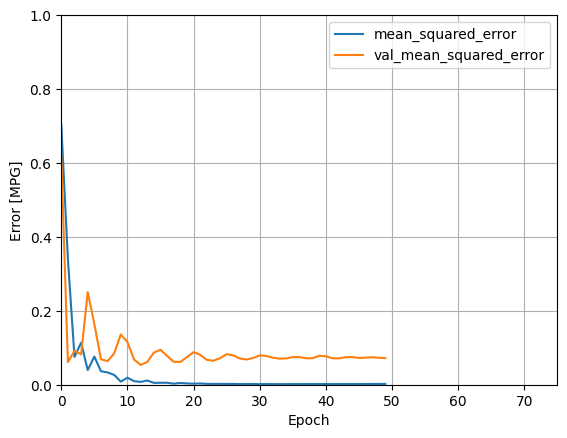

In [33]:
def plot_loss(history):
  plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
  plt.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
  plt.ylim([0, 1])
  plt.xlim([0,75])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [34]:
val_acc_per_epoch = history.history['val_mean_squared_error']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
best_epoch

13

In [35]:
model.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2, verbose=0)
eval_result = model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 40ms/step - loss: 2.7184 - mean_squared_error: 0.0579


In [36]:
from sklearn.metrics import mean_squared_error, make_scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) 
mse_scorer = make_scorer(rmse)

In [37]:
from sklearn.inspection import permutation_importance
results = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring=mse_scorer)
importance = results.importances_mean

1/1 [==============================] - 0s 30ms/step


In [38]:
pd.DataFrame(importance, X_test.columns).sort_values([0], ascending=False).head(20)

,0
"Labor force, female",0.004713
"Population, total",0.003913
"Employment in agriculture, male (% of male employment) (modeled ILO estimate)",0.003307
"Employment in services, female (% of female employment) (modeled ILO estimate)",0.003154
Paid leave is available to fathers (1=yes; 0=no),0.002828
The age at which men and women can retire with partial pension benefits is the same (1=yes; 0=no),0.002806
"Vulnerable employment, total (% of total employment) (modeled ILO estimate)",0.002402
"Population, female",0.002138
"Vulnerable employment, female (% of female employment) (modeled ILO estimate)",0.001984
"Employment in agriculture, female (% of female employment) (modeled ILO estimate)",0.001839


In [39]:
explainer = shap.DeepExplainer(model, X_train.values)
shap_values = explainer.shap_values(X_test.values)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


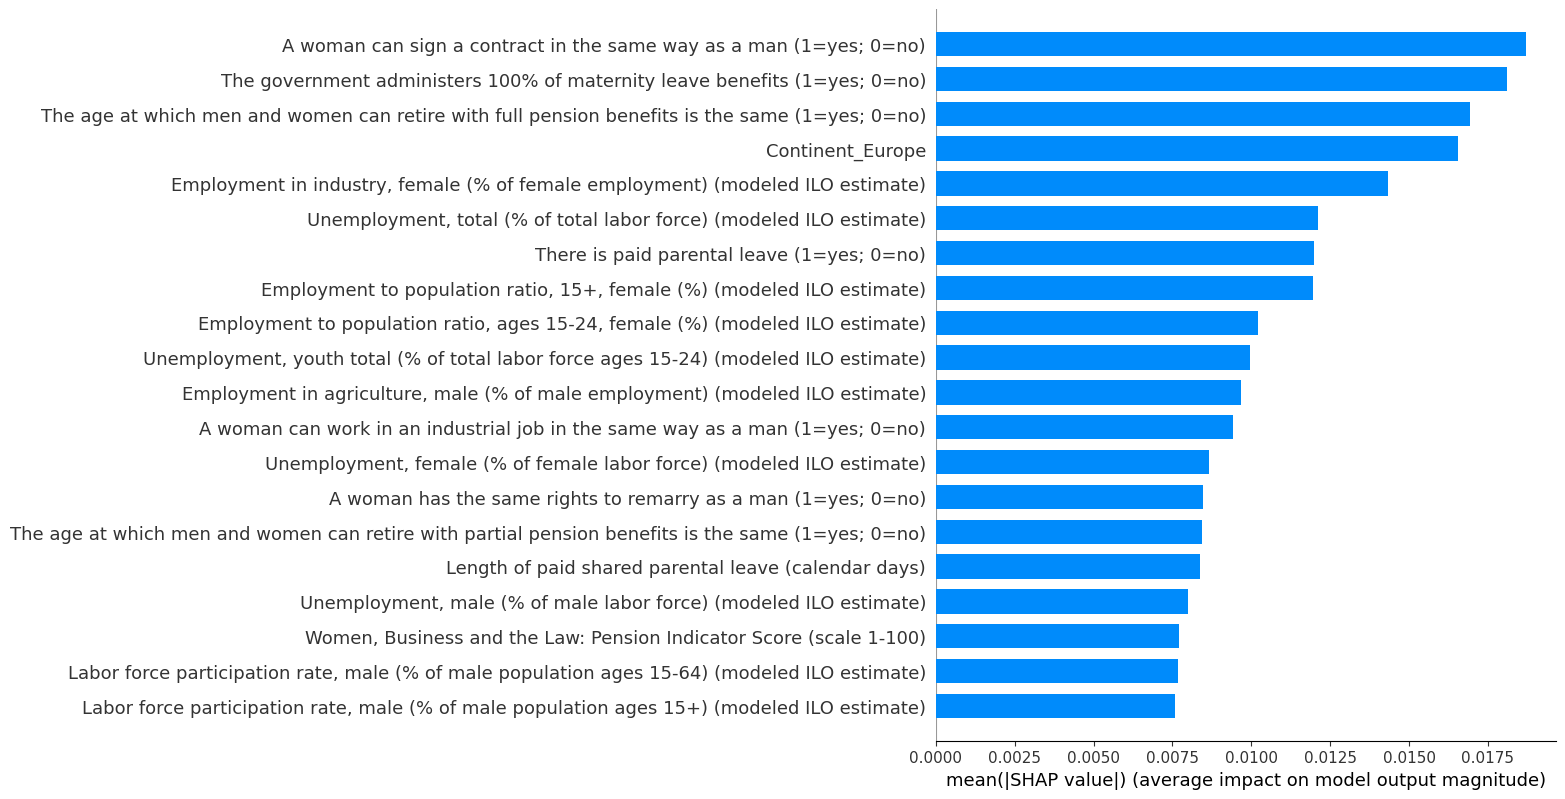

In [40]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = X_test.columns)

In [41]:
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = X_test.columns)

In [ ]:
shap.decision_plot(explainer.expected_value[0].numpy(), shap_values[0][11], features = X_test.iloc[11,:], feature_names = X_test.columns.tolist())

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][11], feature_names = X_test.columns)

In [42]:
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)

32/32 [==============================] - 0s 3ms/step


Permutation explainer:  50%|█████     | 6/12 [00:00<?, ?it/s]

32/32 [==============================] - 0s 3ms/step


Permutation explainer:  67%|██████▋   | 8/12 [00:10<00:01,  2.17it/s]

33/33 [==============================] - 0s 2ms/step


Permutation explainer:  75%|███████▌  | 9/12 [00:11<00:01,  1.68it/s]

33/33 [==============================] - 0s 3ms/step


Permutation explainer:  83%|████████▎ | 10/12 [00:12<00:01,  1.49it/s]

32/32 [==============================] - 0s 3ms/step


Permutation explainer:  92%|█████████▏| 11/12 [00:13<00:00,  1.38it/s]

33/33 [==============================] - 0s 2ms/step


Permutation explainer: 100%|██████████| 12/12 [00:14<00:00,  1.28it/s]

32/32 [==============================] - 0s 3ms/step


Permutation explainer: 13it [00:15,  2.19s/it]                        


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


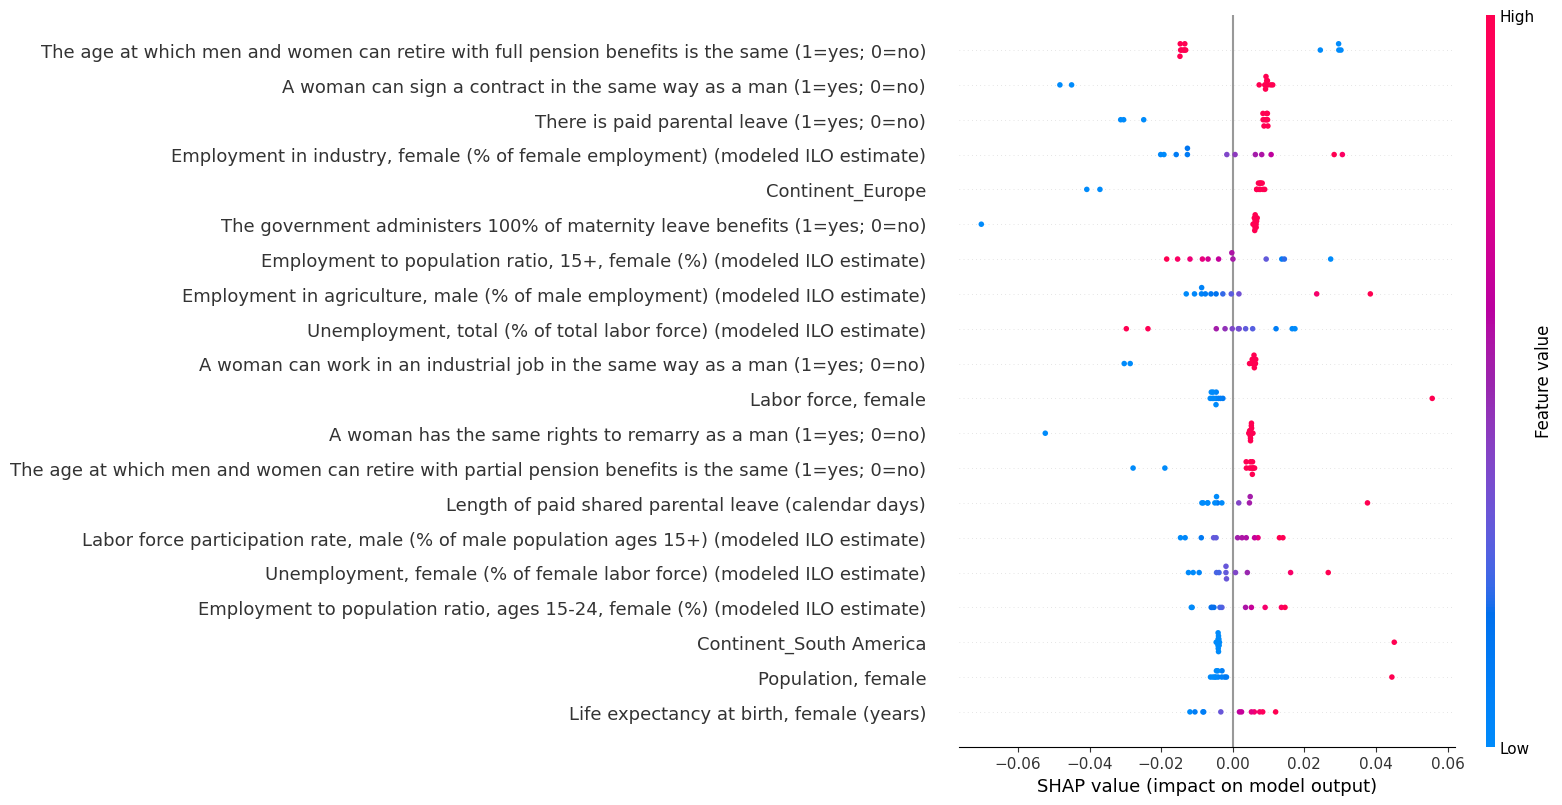

In [43]:
shap.summary_plot(shap_values, plot_type='dot')